<a href="https://colab.research.google.com/github/happyrabbit/IntroDataScience/blob/master/Python/MINST_with_one_hidden_layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

Import packages for the notebook.

In [12]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
import matplotlib.pyplot as plt

# Load Data

Let's load the MINST data set. 

In [13]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

img_width = X_train.shape[1]
img_height = X_train.shape[2]

# one hot encode outputs
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [14]:
print('The shape of X_train is: ' + str(X_train.shape)) 
print('The shape of y_train is: ' + str(y_train.shape)) 
print('The shape of X_test is: ' + str(X_test.shape)) 
print('The shape of y_test is: ' + str(y_test.shape))
print('I have %d traning and %d testing examples!' %(X_train.shape[0], X_test.shape[0])) 

The shape of X_train is: (60000, 28, 28)
The shape of y_train is: (60000, 10)
The shape of X_test is: (10000, 28, 28)
The shape of y_test is: (10000, 10)
I have 60000 traning and 10000 testing examples!


Check some of the input images 

Label: [3]


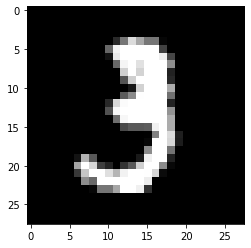

In [15]:
# assign the number of the image to show
img_id = 10
plt.imshow(X_train[img_id], cmap='gray')
print("Label: "+ str(np.where(y_train[img_id] ==1)[0]))

Scale and reshape the inputs and outputs.

In [16]:
# Scale the input
X_train = X_train / 255.
X_test = X_test / 255.

# Flatten the input
X_train = np.array([X_train[i].flatten() for i in range(0,X_train.shape[0])])
X_test = np.array([X_test[i].flatten() for i in range(0,X_test.shape[0])])

# Reshape the input and output
X_train = X_train.T
X_test = X_test.T
y_train = y_train.T
y_test = y_test.T

print('The shape of X_train is: ' + str(X_train.shape)) 
print('The shape of y_train is: ' + str(y_train.shape)) 
print('The shape of X_test is: ' + str(X_test.shape)) 
print('The shape of y_test is: ' + str(y_test.shape))

The shape of X_train is: (784, 60000)
The shape of y_train is: (10, 60000)
The shape of X_test is: (784, 10000)
The shape of y_test is: (10, 10000)


# One Hidden Layer Neural Network
<center><img src="https://raw.githubusercontent.com/happyrabbit/course2020/master/slides/02DeepLearning/DNN/images/1hiddenexp.png" width="700"/></center>


# Defining the neural network structure

- `n_x` -- the size of the input layer
- `n_h` -- the size of the hidden layer
- `n_y` -- the size of the output layer


#  Initialize the model's parameters

- Initialize the weights matrices, $W_1$ and $W_2$, with random values.
- Initialize the bias vectors, $b_1$ and $b_2$, as zeros.

In [18]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
        
    W1 = np.random.randn(n_h, n_x) * 0.001
    b1 = np.zeros(shape=(n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.001
    b2 = np.zeros(shape=(n_y, 1))
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

# Defining Activation Functions and the Gradients

In [19]:
def ReLU(Z1):
    """
    Argument:
    Z1 -- the input of hidden layer activation function
    
    Returns:
    A1 -- activations from the hidden layer
    """
    A1 = np.maximum(Z1, 0)
    return A1

def ReLU_dev(Z1):
    """
    Argument:
    Z1 -- the input of hidden layer activation function
    
    Returns:
    dZ1 -- gradient of ReLU given input Z1
    """
    positive = Z1 > 0
    dZ1 = np.zeros(Z1.shape)
    dZ1[positive] = 1
    return dZ1

def softmax(Z2):
    """
    Argument:
    Z2 -- the input of output layer activation function
    
    Returns:
    A2 -- activations from the hidden layer
    """
    exp_scores = np.exp(Z2 - Z2.max(axis = 0, keepdims=True))
    A2 = exp_scores / exp_scores.sum(axis = 0, keepdims=True)
    return A2

# Loss and Accuracy


In [20]:
def compute_cost(A2, Y, parameters):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (10, number of examples)
    Y -- "true" labels vector of shape (10, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    
    Returns:
    cost -- cross-entropy cost given equation (13)
    """
    m = Y.shape[1] # number of example
    # Retrieve W1 and W2 from parameters
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # Compute the cross-entropy cost
    logprobs = np.multiply(np.log(A2), Y)
    cost = - np.sum(logprobs) / m
    
    cost = np.squeeze(cost)     # makes sure cost is the dimension we expect. 
                                # E.g., turns [[17]] into 17 
    assert(isinstance(cost, float))
    return cost

# Forward Propagation

In [21]:
def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # Implement Forward Propagation to calculate A2 (probabilities)
    Z1 = np.dot(W1, X) + b1
    A1 = ReLU(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = softmax(Z2)
    
    assert(A2.shape == (10, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

# Backward Propagation

In [22]:
def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (784, number of examples)
    Y -- "true" labels vector of shape (10, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    W1 = parameters['W1']
    W2 = parameters['W2']
        
    # Retrieve also A1 and A2 from dictionary "cache".
    A1 = cache['A1']
    A2 = cache['A2']
    Z1 = cache['Z1']
    Z2 = cache['Z2']
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    dZ2= A2 - Y
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), ReLU_dev(Z1))
    dW1 = (1 / m) * np.dot(dZ1, X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [26]:
def update_parameters(parameters, grads, learning_rate= 0.1, l2 = 0):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    learning_rate -- a number between 0 to 1
    l2 -- parameter for l2 penality, a number >= 0
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # Retrieve each gradient from the dictionary "grads"
    dW1 = grads['dW1'] + np.sum(l2*W1)
    db1 = grads['db1'] 
    dW2 = grads['dW2'] + np.sum(l2*W2)
    db2 = grads['db2'] 
    
    # Update rule for each parameter
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

# Build Your Own Neural Network 

In [27]:
def nn_model(X, Y, n_h, num_iterations=10000, print_cost=False, learning_rate= 0.1, l2 = 0):
    """
    Arguments:
    X -- dataset of shape (784, number of examples)
    Y -- labels of shape (10, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    learning_rate -- a number between 0 to 1
    l2 -- parameter for l2 penality, a number >= 0
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    costs -- a list of cost per 100 interations
    """
    
    np.random.seed(1)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    costs = []
    
    # Initialize parameters, then retrieve W1, b1, W2, b2. Inputs: "n_x, n_h, n_y". Outputs = "W1, b1, W2, b2, parameters".
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):
         
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X, parameters)
        
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A2, Y, parameters)
 
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters, cache, X, Y)
 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads, learning_rate= learning_rate, l2 = l2)
        
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
          print ("Cost after iteration %i: %f" % (i, cost))
        if i % 100 == 0:
          costs.append(cost)

    return parameters, costs

In [ ]:
# Build a model with a n_h-dimensional hidden layer
parameters, costs = nn_model(X_train, y_train, n_h = 4, num_iterations=10000, print_cost=True)

Cost after iteration 0: 2.302587
Cost after iteration 1000: 0.565407
Cost after iteration 2000: 0.499799
Cost after iteration 3000: 0.479786
Cost after iteration 4000: 0.466273


In [ ]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    A2, cache = forward_propagation(X, parameters)

    predictions = np.argmax(A2, axis = 0)
    return predictions